In [2]:
from fastcore.xtras import load_pickle
import pandas as pd 
import os 
from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime

import sys
sys.path.append("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/")
from plotutils import *

plt.style.use("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/kevin.mplstyle")

FOLDER = 'out'

In [3]:
if not os.path.exists(FOLDER):
    raise FileExistsError('Cannot find folder {}'.format(FOLDER))

all_res = glob(f'{FOLDER}/*.pkl')
print('Pickles found in {}: {}'.format(FOLDER, len(all_res)))

Pickles found in out: 30


In [4]:

compiled_res_list = []
conf_mats = []

for results in all_res:
    res_full = load_pickle(results)
    res = res_full['results']
    summary = {
        'size': res_full['train_size'],
        #'representation': res_full['data_summary']['representation'],
        'target': res_full['data_summary']['target'],
        'accuracy': res['accuracy'],
        'f1_macro': res['f1_macro'],
        'f1_micro': res['f1_micro'],
        'kappa': res['kappa'],
        'num_epochs': res_full['config']['tune_settings']['num_train_epochs'],
        'lr': res_full['config']['tune_settings']['learning_rate'],
        'bins': len(set(res['all_y_true'])),
        'test_size': len(res['all_y_true'])
       
    }
    confusion_matrix = {
        'all_y_true':res['all_y_true'],
        'all_y_pred':res['all_y_pred']
    }
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)

In [5]:
compiled_res = pd.DataFrame(compiled_res_list)
grouped_res =compiled_res.groupby(['bins', 'num_epochs', 'target', 'size']).agg(['mean', 'sem'])

In [6]:
grouped_res

accuracy            f1_macro            \
                                         mean       sem      mean       sem   
bins num_epochs target         size                                           
2    10         completion_raw 5     0.000000  0.000000  0.000000  0.000000   
                               10    0.000000  0.000000  0.000000  0.000000   
                               20    0.000000  0.000000  0.000000  0.000000   
     25         completion_raw 5     0.000000  0.000000  0.000000  0.000000   
                               10    0.000000  0.000000  0.000000  0.000000   
                               20    0.888889  0.055556  0.885714  0.057143   
     50         completion_raw 5     0.857143  0.027493  0.852230  0.030278   
                               10    0.895833  0.020833  0.891635  0.021871   
                               15    0.909091  0.000000  0.806756  0.093906   
                               20    0.888889  0.055556  0.868783  0.067227   

                                     f1_micro               kappa            \
                                         mean       sem      mean       sem   
bins num_epochs target         size                                           
2    10         completion_raw 5     0.000000  0.000000  0.000000  0.000000   
                               10    0.000000  0.000000  0.000000  0.000000   
                               20    0.000000  0.000000  0.000000  0.000000   
     25         completion_raw 5     0.000000  0.000000  0.000000  0.000000   
                               10    0.000000  0.000000  0.000000  0.000000   
                               20    0.888889  0.055556  0.777778  0.111111   
     50         completion_raw 5     0.857143  0.027493  0.706994  0.061189   
                               10    0.895833  0.020833  0.784767  0.043368   
                               15    0.909091  0.000000  0.807560  0.007606   
                               20    0.888889  0.055556  0.746032  0.129926   

                                         lr      test_size       
                                       mean  sem      mean  sem  
bins num_epochs target         size                              
2    10         completion_raw 5     0.0003  0.0      21.0  0.0  
                               10    0.0003  0.0      16.0  0.0  
                               20    0.0003  0.0       6.0  0.0  
     25         completion_raw 5     0.0003  0.0      21.0  0.0  
                               10    0.0003  0.0      16.0  0.0  
                               20    0.0003  0.0       6.0  0.0  
     50         completion_raw 5     0.0003  0.0      21.0  0.0  
                               10    0.0003  0.0      16.0  0.0  
                               15    0.0003  0.0      11.0  0.0  
                               20    0.0003  0.0       6.0  0.0

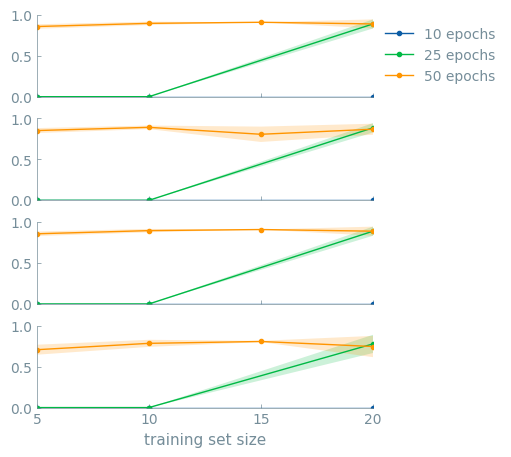

In [8]:
from scipy.stats import sem
from scipy.constants import golden
ONE_COL_WIDTH_INCH = 5
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

BINS = 2
REPRESENTATION = 'completion_raw'

fig, ax = plt.subplots(4, 1,figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH),constrained_layout = True , sharex=True)
 
for num_epochs in [10, 25, 50]:
    for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
        ax[i].plot(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index, 
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'],
            marker='o',
            label=f'{num_epochs} epochs'
        )
        ax[i].fill_between(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index,
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] - grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] + grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            alpha=0.2
        )
        ax[i].set_ylim(0,1)
        #ax[i].set_title(metric)
        ax[i].set_xticks((list(compiled_res['size'].unique())))
    #ylabel_top('accuracy', ax=ax[0])
    #ylabel_top(r'F$_1$ macro', ax=ax[1])
    #ylabel_top(r'F$_1$ micro', ax=ax[2])
    #ylabel_top(r'$\kappa$', ax=ax[3])
ax[-1].set_xlabel('training set size')

ax[0].legend(bbox_to_anchor=(1, 1))


#matplotx.line_labels(ax[0])
now = datetime.now().strftime('%Y%m%d_%H%M') 
#fig.suptitle('MIL-140 Synthesis - {} - {}'.format(REPRESENTATION, 'binary'), fontsize=16)
fig.savefig(f'{now}_MOF_synthesis-{REPRESENTATION}-binary-{BINS}bin-classification-results.pdf', bbox_inches='tight')

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.80      1.00      0.89         8

    accuracy                           0.90        21
   macro avg       0.90      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21



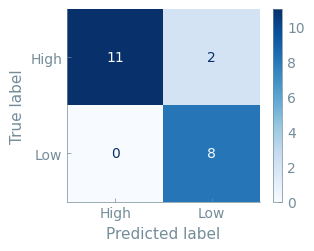

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21



<Figure size 330x250 with 0 Axes>

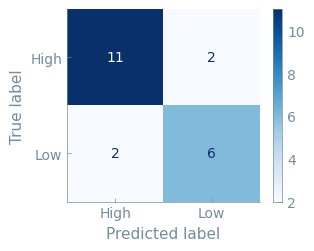

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      13.0
                   1       0.00      0.00      0.00       8.0

            accuracy                           0.00      21.0
           macro avg       0.00      0.00      0.00      21.0
        weighted avg       0.00      0.00      0.00      21.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.73      1.00      0.84         8

    accuracy                           0.86        21
   macro avg       0.86      0.88      0.86        21
weighted avg       0.90      0.86      0.86        21



/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.loc

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

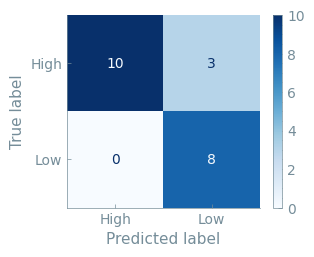

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.86      1.00      0.92         6

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



<Figure size 330x250 with 0 Axes>

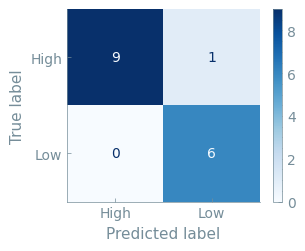

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      10.0
                   1       0.00      0.00      0.00       6.0

            accuracy                           0.00      16.0
           macro avg       0.00      0.00      0.00      16.0
        weighted avg       0.00      0.00      0.00      16.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      10.0
                   1       0.00      0.00      0.00       6.0

            accuracy                           0.00      16.0
           macro avg       0.00      0.00      0.00      16.0
        weighted avg       0.00      0.00      0.00      16.0



/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.loc

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      10.0
                   1       0.00      0.00      0.00       6.0

            accuracy                           0.00      16.0
           macro avg       0.00      0.00      0.00      16.0
        weighted avg       0.00      0.00      0.00      16.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      13.0
                   1       0.00      0.00      0.00       8.0

            accuracy                           0.00      21.0
         

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

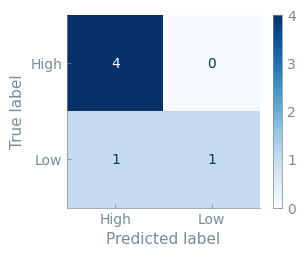

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.83      0.83      0.83         6

    accuracy                           0.88        16
   macro avg       0.87      0.87      0.87        16
weighted avg       0.88      0.88      0.88        16



<Figure size 330x250 with 0 Axes>

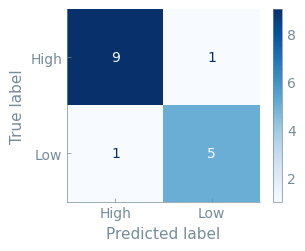

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.67      1.00      0.80         2

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6



<Figure size 330x250 with 0 Axes>

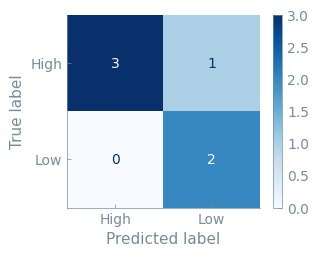

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00       4.0
                   1       0.00      0.00      0.00       2.0

            accuracy                           0.00       6.0
           macro avg       0.00      0.00      0.00       6.0
        weighted avg       0.00      0.00      0.00       6.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.loc

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

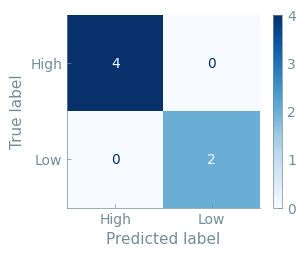

/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.loc

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00       4.0
                   1       0.00      0.00      0.00       2.0

            accuracy                           0.00       6.0
           macro avg       0.00      0.00      0.00       6.0
        weighted avg       0.00      0.00      0.00       6.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      10.0
                   1       0.00      0.00      0.00       6.0

            accuracy                           0.00      16.0
           macro avg       0.00      0.00      0.00      16.0
        weighted avg       0.00      0.00      0.00      16.0

The n

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

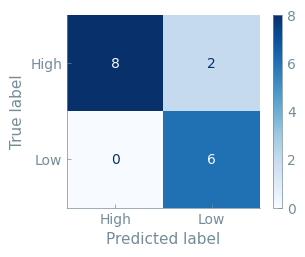

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00       4.0
                   1       0.00      0.00      0.00       2.0

            accuracy                           0.00       6.0
           macro avg       0.00      0.00      0.00       6.0
        weighted avg       0.00      0.00      0.00       6.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.loc

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

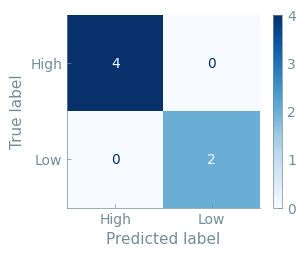

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.80      1.00      0.89         4

    accuracy                           0.91        11
   macro avg       0.90      0.93      0.91        11
weighted avg       0.93      0.91      0.91        11



<Figure size 330x250 with 0 Axes>

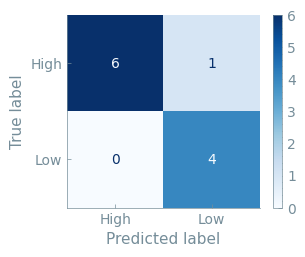

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      10.0
                   1       0.00      0.00      0.00       6.0

            accuracy                           0.00      16.0
           macro avg       0.00      0.00      0.00      16.0
        weighted avg       0.00      0.00      0.00      16.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      10.0
                   1       0.00      0.00      0.00       6.0

            accuracy                           0.00      16.0
           macro avg       0.00      0.00      0.00      16.0
        weighted avg       0.00      0.00      0.00      16.0

The n

/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.loc

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      13.0
                   1       0.00      0.00      0.00       8.0

            accuracy                           0.00      21.0
           macro avg       0.00      0.00      0.00      21.0
        weighted avg       0.00      0.00      0.00      21.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      13.0
                   1       0.00      0.00      0.00       8.0

            accuracy                           0.00      21.0
           macro avg       0.00      0.00      0.00      21.0
        weighted avg       0.00      0.00      0.00      21.0

The n

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

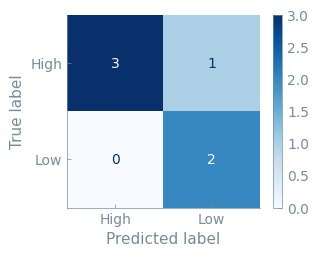

                      precision    recall  f1-score   support

-9223372036854775808       0.00      0.00      0.00       0.0
                   0       0.00      0.00      0.00      13.0
                   1       0.00      0.00      0.00       8.0

            accuracy                           0.00      21.0
           macro avg       0.00      0.00      0.00      21.0
        weighted avg       0.00      0.00      0.00      21.0

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.67      1.00      0.80         2

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6



/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.loc

<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

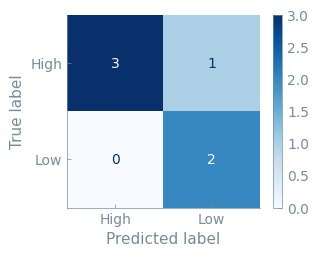

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.75      0.86         4
          11       0.00      0.00      0.00         0

    accuracy                           0.91        11
   macro avg       0.67      0.58      0.62        11
weighted avg       1.00      0.91      0.95        11

The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.75      0.86         4

    accuracy                           0.91        11
   macro avg       0.94      0.88      0.90        11
weighted avg       0.92      0.91      0.91        11



/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 330x250 with 0 Axes>

<Figure size 330x250 with 0 Axes>

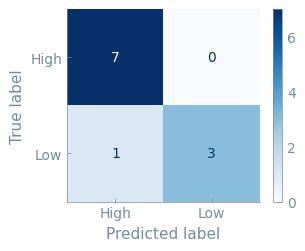

<Figure size 330x250 with 0 Axes>

In [9]:
from sklearn.metrics import classification_report
from sklearn import metrics
for index, _ in enumerate(conf_mats):
    try:
        preds = conf_mats[index]
        actual	= preds['all_y_true']
        predicted	= preds['all_y_pred']

        gpt_metrics = compiled_res.iloc[index]
        confusion_matrix = metrics.confusion_matrix(actual, predicted)
        print(classification_report(actual, predicted))

        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['High','Low'])
        cm_display.plot(cmap=plt.cm.Blues)


        #plt.title('{} \n(Accuracy : {}%)'.format(bar_labels[gpt_metrics['target']],round(100*gpt_metrics['accuracy'], 2)))
        if not os.path.exists('ConfusionMatrices'):
            os.mkdir('ConfusionMatrices')
        plt.savefig('ConfusionMatrices/{}_{}_size{}_#epochs_{}_lr_{}.png'.format(FOLDER , gpt_metrics['target'], gpt_metrics['size'], gpt_metrics['num_epochs'], gpt_metrics['lr']))
        plt.show()
    except Exception as e:
        print(e)
    plt.clf()